In [1]:
import numpy as np
from typing import List
from scipy.stats import levy_stable


def p_stable(p_list:List[float],
             alpha = 1,
             beta = 0,loc = 0,scale = 1):
    n = len(p_list)
    t = np.sum(levy_stable.ppf(p_list, alpha, beta, loc=loc, scale=scale))
    return levy_stable.cdf(t, alpha, beta, loc=loc*n, scale=scale*(n**(1/alpha)))



def p_alpha02(p_list:List[float]):
    return p_stable(p_list, alpha = 0.2)


def p_alpha05(p_list:List[float]):
    return p_stable(p_list, alpha = 0.5)


def p_alpha08(p_list:List[float]):
    return p_stable(p_list, alpha = 0.8)


def p_cauchy(p_list:List[float]):
    return p_stable(p_list, alpha = 1)


def p_alpha12(p_list:List[float]):
    return p_stable(p_list, alpha = 1.2)


def p_alpha15(p_list:List[float]):
    return p_stable(p_list, alpha = 1.5)


def p_alpha18(p_list:List[float]):
    return p_stable(p_list, alpha = 1.8)


def p_gaussian(p_list:List[float]):
    return p_stable(p_list, alpha = 2)


def p_mean(p_list:List[float]):
    p_list = np.array(p_list)
    return np.mean(p_list)
        

ps = [0.02,0.05,0.09]

print(p_alpha02(ps))
print(p_alpha05(ps))
print(p_alpha08(ps))
print(p_cauchy(ps))
print(p_alpha12(ps))
print(p_alpha15(ps))
print(p_alpha18(ps))
print(p_gaussian(ps))

###
print('---')
### scale = scale * n**(1/alpha) -> scale = scale * n

def p_stable(p_list:List[float],
             alpha = 1,
             beta = 0,loc = 0,scale = 1):
    n = len(p_list)
    t = np.sum(levy_stable.ppf(p_list, alpha, beta, loc=loc, scale=scale))
    return levy_stable.cdf(t, alpha, beta, loc=loc*n, scale=scale*n)


print(p_alpha02(ps))
print(p_alpha05(ps))
print(p_alpha08(ps))
print(p_cauchy(ps))
print(p_alpha12(ps))
print(p_alpha15(ps))
print(p_alpha18(ps))
print(p_gaussian(ps))

0.0574940281614672
0.05303009324371866
0.04374821970777443
0.037060391530110204
0.030537071541055893
0.020861456473774465
0.010003215096890394
0.0018101848857633464
---
0.024745155410379027
0.031348967067965416
0.035356297427499905
0.037060391530110204
0.03831361775429687
0.03998747279493842
0.04382565669365768
0.046499493919458845


---

In [2]:
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from ecit import *


def ecit_simu_alpha(n_list=[100, 200, 500, 1000, 2000, 4000],
              t = 100,
              cit = kcit,
              k = 5,
              ensembles=[p_gaussian, p_alpha18, p_alpha15, p_alpha12, p_cauchy, p_alpha05],
              show_progress=True):
    
    results = []

    for n in n_list:

        eI = [0] * len(ensembles)
        eII = [0] * len(ensembles)
        tim = 0
        start_time = time.time()
        iteration_loop = tqdm(range(t), desc=f"n={n}", leave=True, dynamic_ncols=True) if show_progress else range(t)

        for sed in iteration_loop:
            np.random.seed(sed)
            random.seed(sed)
            dataI = np.hstack((generate_samples(n=n,indp='C',z_dis='laplace',noise_dis='laplace',noise_std=0.3)))
            dataII = np.hstack((generate_samples(n=n,indp='Nc',z_dis='laplace',noise_dis='laplace',noise_std=0.3)))

            obj_ECIT = ECIT(dataI, cit, ensembles[0], k)
            _, pI_list = obj_ECIT([0], [1], [2], return_p_list=True)
            obj_ECIT = ECIT(dataII, cit, ensembles[0], k)
            _, pII_list = obj_ECIT([0], [1], [2], return_p_list=True)

            for j, ensfunc in enumerate(ensembles):
                pI = ensfunc(pI_list)
                pII = ensfunc(pII_list)
                if pI<0.05:
                    eI[j] += 1
                if pII>0.05:
                    eII[j] += 1
    

        end_time = time.time()
        tim = end_time - start_time
        eI = [count / t for count in eI]
        eII = [count / t for count in eII]

        results.append({
            'n': n,
            'eI': eI,
            'eII': eII,
            'tim': tim
        })

    final_results = []
    for j in range(len(ensembles)):
        result_array = np.array([
            [re['eI'][j] for re in results],
            [re['eII'][j] for re in results],
            [re['tim'] for re in results]
        ])
        final_results.append(result_array)

    return final_results




def show_results_k(results, ensembles, k, n_list):
    dir = {}
    for p_ensemble, result in zip(ensembles, results):
        key_name = f"Ensemble (k={k}, {p_ensemble.__name__})" if k > 1 else f"Default (k=1)"
        dir[key_name] = result

    fig, axes = plt.subplots(2, 2, figsize=(16, 10), dpi=300, sharex=True)
    (ax_eI, ax_eII), (ax_eSum, ax_tim) = axes

    for label, result in dir.items():
        eI, eII, tim = result
        eSum = eI + eII

        ax_eI.plot(n_list, eI, label=label)
        ax_eII.plot(n_list, eII, label=label)
        ax_eSum.plot(n_list, eSum, label=label)
        ax_tim.plot(n_list, tim, label=label)

    ax_eI.set_title("Error I")
    ax_eI.set_ylabel("Error Rate")

    ax_eII.set_title("Error II")

    ax_eSum.set_title("Error I + Error II")
    ax_eSum.set_xlabel("Sample Size (n)")   
    ax_eSum.set_ylabel("Error Rate")


    ax_tim.set_title("Execution Time")
    ax_tim.set_ylabel("Time (s)")
    ax_tim.set_xlabel("Sample Size (n)")

    fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=4, fontsize=12)

    ax_tim.set_xticks(n_list)
    ax_eSum.set_xticks(n_list)

    plt.tight_layout()
    plt.show()

/Users/gzk/anaconda3/envs/graph/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
n_list=[100, 200, 500, 1000]
ensembles=[p_gaussian, p_alpha18, p_alpha15, p_alpha12, p_cauchy, p_alpha05]
k = 5
t = 50

n=1000: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]


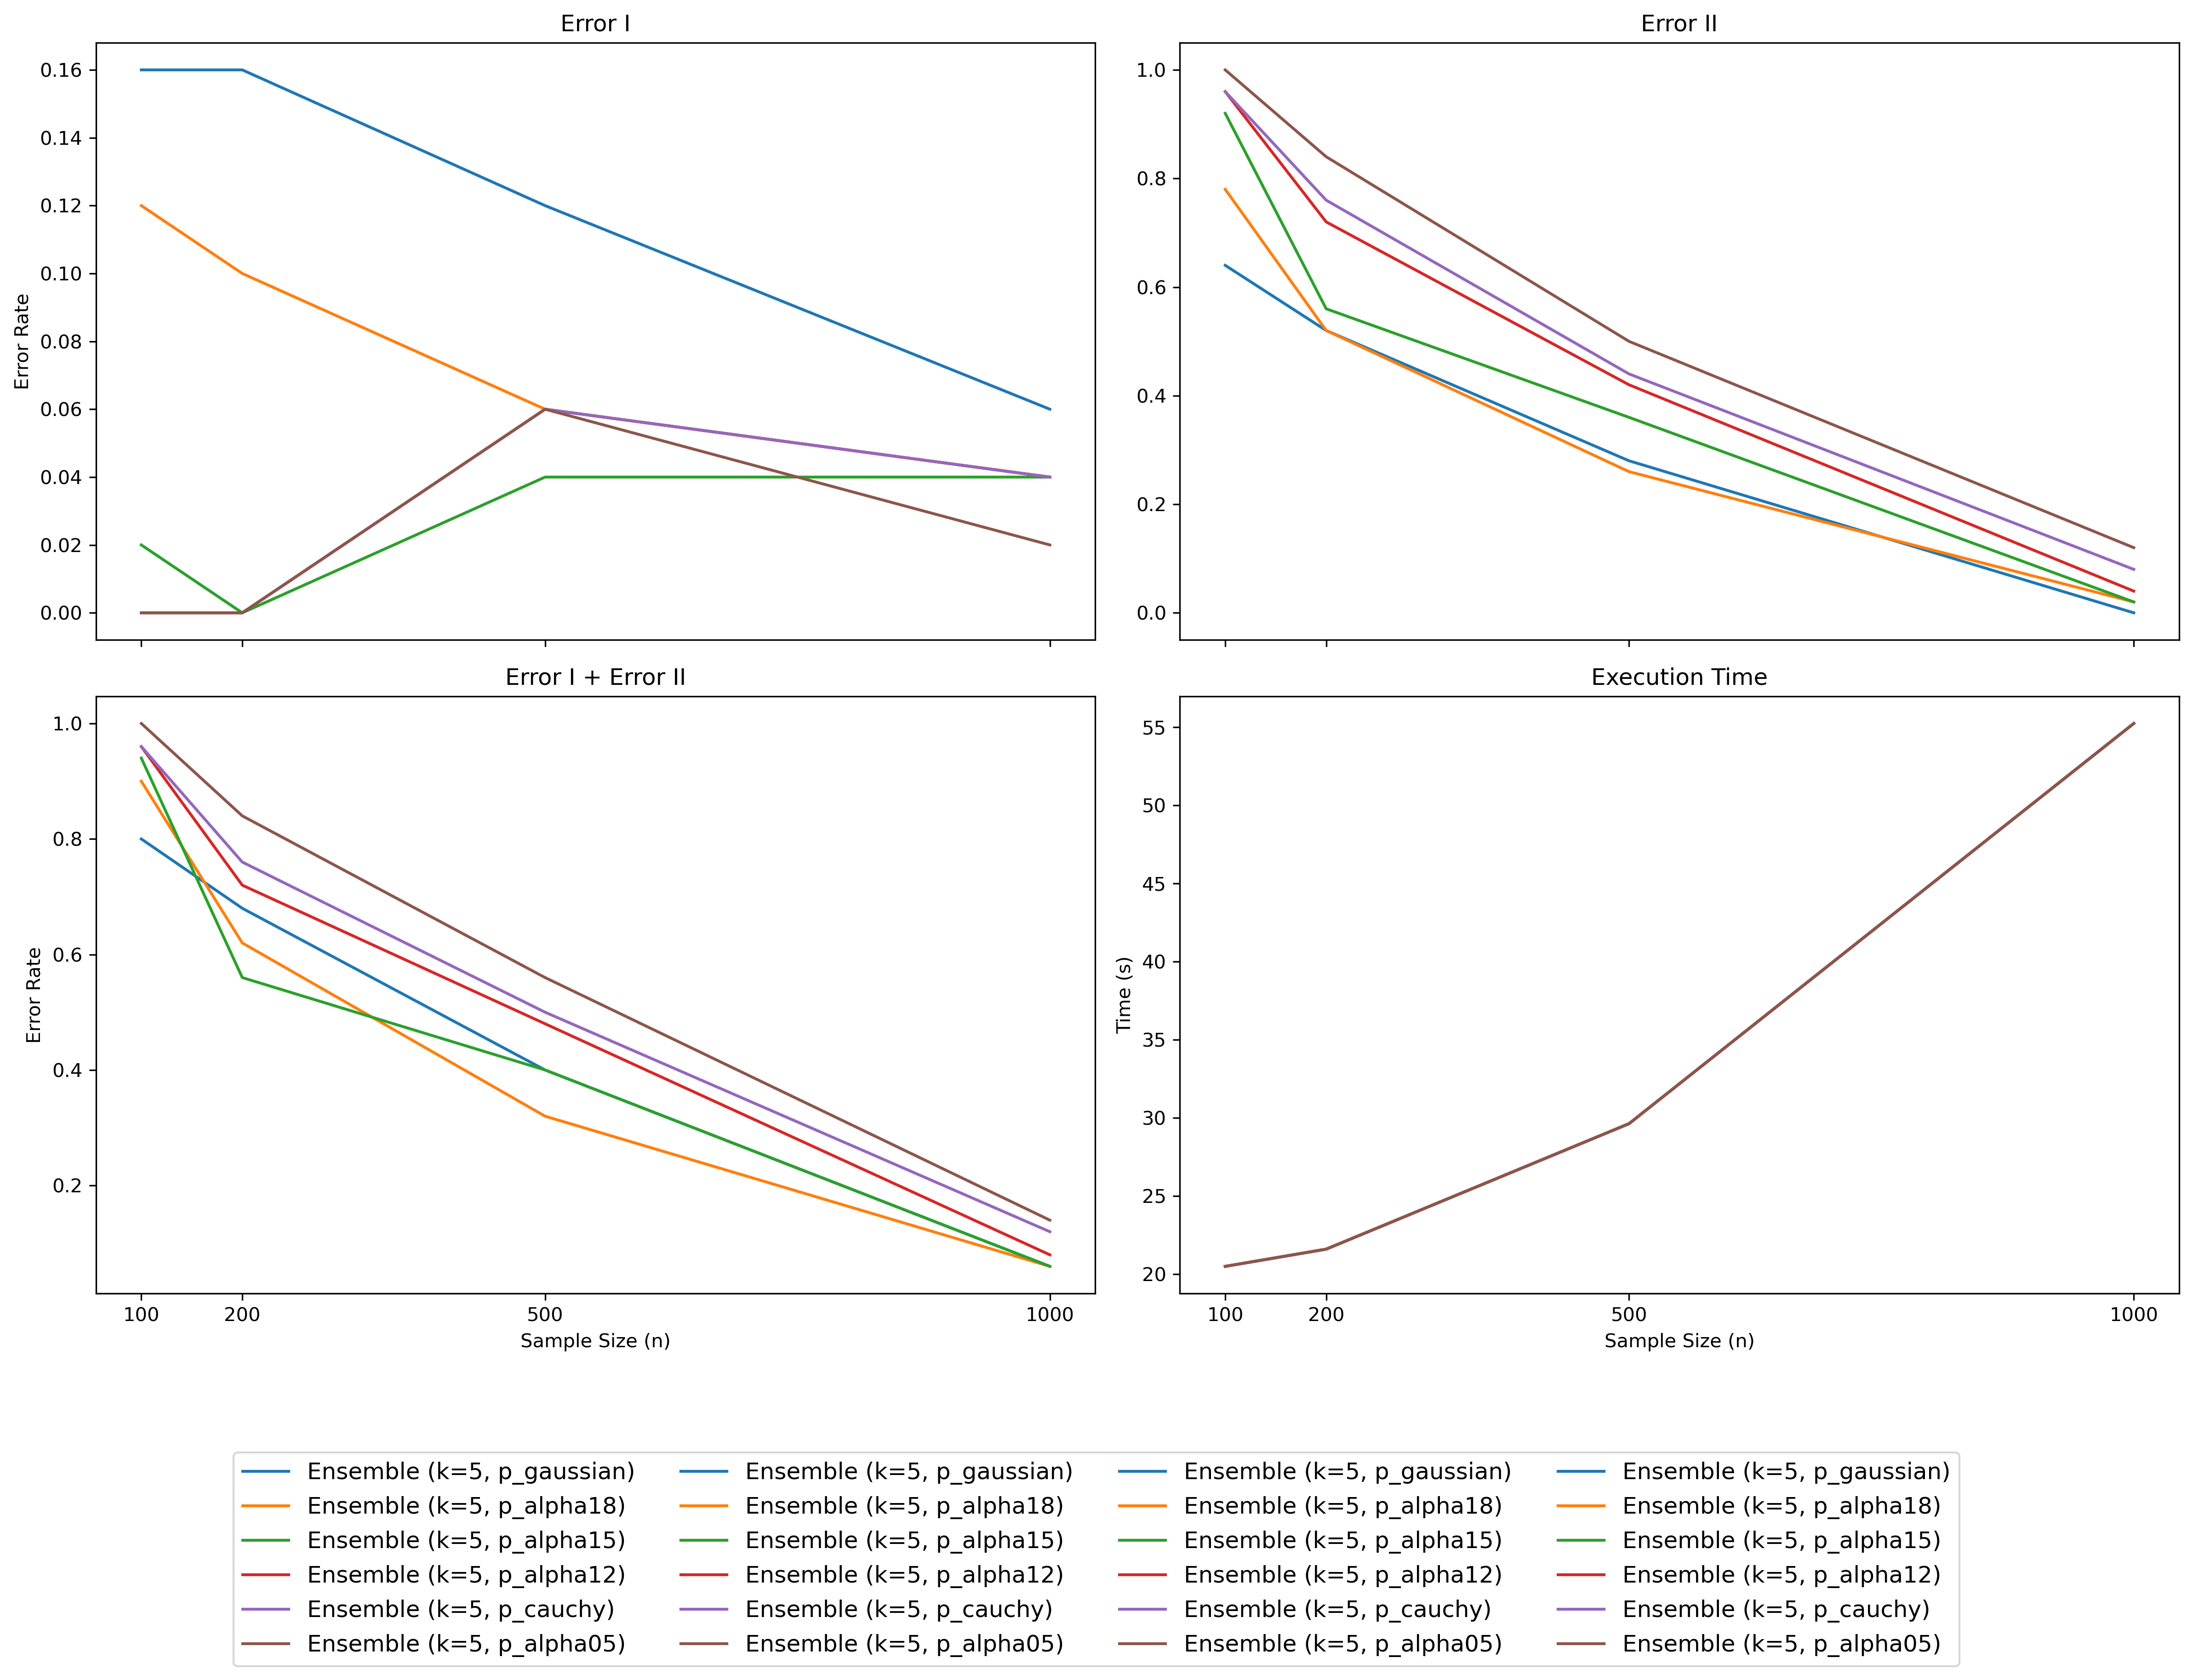

In [4]:
cit = kcit

results = ecit_simu_alpha(n_list=n_list, t=t, cit=cit, k=k, ensembles=ensembles)
show_results_k(results, ensembles, k, n_list)

In [ ]:
cit = cmiknn

results = ecit_simu_alpha(n_list=n_list, t=t, cit=cit, k=k, ensembles=ensembles)
show_results_k(results, ensembles, k, n_list)

n=500:   4%|▍         | 2/50 [00:52<20:55, 26.15s/it]

In [ ]:
cit = nnscit

results = ecit_simu_alpha(n_list=n_list, t=t, cit=cit, k=k, ensembles=ensembles)
show_results_k(results, ensembles, k, n_list)